In [1]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats


%matplotlib inline

As an example, let's look at real mobile game data. Specifically, we will look into ads watched per hour and in-game currency spend per day:

In [2]:
import pandas as pd
chemin_fichier="C:/Users/hatta/OneDrive/Bureau/stage1/demande_PFVLSM-L90027847.xlsx"
# Lire toutes les feuilles du fichier Excel en utilisant pandas
dataframes = pd.read_excel(chemin_fichier)



In [3]:
xls = pd.ExcelFile(chemin_fichier)
sheet_names = xls.sheet_names

In [4]:
base=dataframes.set_index(['date'])


In [5]:
sheet_names


['PFVLSM-L90027847']

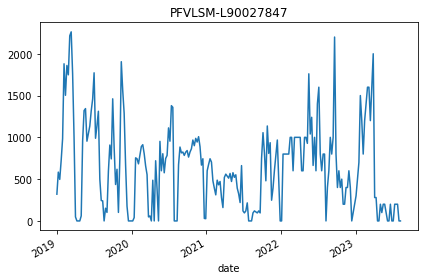

In [6]:
import matplotlib.pyplot as plt
base.demand.plot(title=sheet_names[0])
plt.tight_layout();
plt.show()

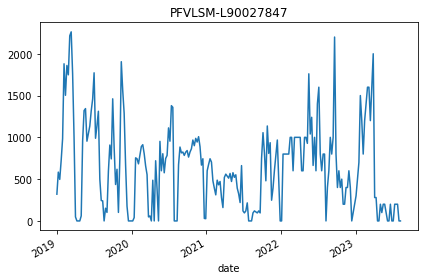

In [7]:
import matplotlib.pyplot as plt
base.demand.plot(title=sheet_names[0])
plt.tight_layout();
plt.show()

## Forecast quality metrics

Before we begin forecasting, let's understand how to measure the quality of our predictions and take a look at the most commonly used metrics.

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): this is an interpretable metric because it has the same unit of measurment as the initial series, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error): again, an interpretable metric that is particularly interesting because it is robust to outliers, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): the most commonly used metric that gives a higher penalty to large errors and vice versa, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$

```python
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

In [8]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Now that we know how to measure the quality of the forecasts, let's see what metrics we can use and how to translate the results for the boss. After that, one small detail remains - building the model.

# Move, smoothe, evaluate

Let's start with a naive hypothesis: "tomorrow will be the same as today". However, instead of a model like $\hat{y}_{t} = y_{t-1}$ (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its $k$ previous values. Therefore, we will use the **moving average**.

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [9]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(base.demand, 4) # prediction for the last observed day (past 24 hours)

100.0

Unfortunately, we cannot make predictions far in the future -- in order to get the value for the next step, we need the previous values to be actually observed. But moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with [`DataFrame.rolling(window).mean()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

Let's smooth by the previous 4 hours.

In [10]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

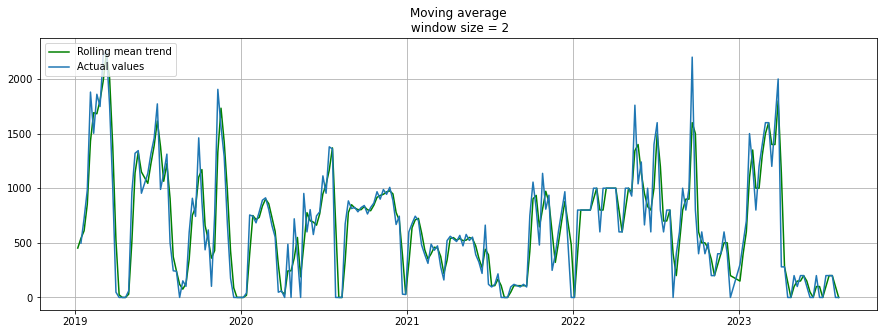

In [11]:
plotMovingAverage(base.demand, 2)

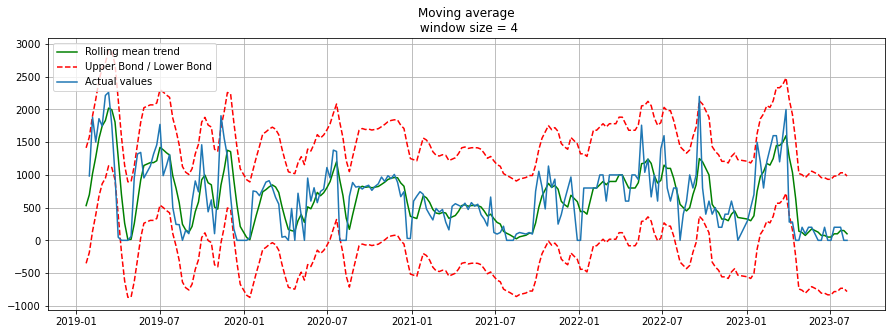

In [12]:
plotMovingAverage(base.demand, 4, plot_intervals=True)

Now, let's create a simple anomaly detection system with the help of moving average. Unfortunately, in this particular dataset, everything is more or less normal, so we will intentionally make one of the values abnormal in our dataframe `ads_anomaly`.

Let's see if this simple method can catch the anomaly.

Neat! What about the second series?

In [14]:
forecast_steps=8

In [15]:
forecast_8_weeks = pd.DataFrame()
forecast_dates = pd.date_range(base.demand.index[-1], periods=forecast_steps + 1, freq='W-MON')[:]



In [16]:
forecast_dates


DatetimeIndex(['2023-08-14', '2023-08-21', '2023-08-28', '2023-09-04',
               '2023-09-11', '2023-09-18', '2023-09-25', '2023-10-02',
               '2023-10-09'],
              dtype='datetime64[ns]', freq='W-MON')

In [17]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [18]:
weighted_average(base.demand, [0.6, 0.3, 0.1])

20.0

## Exponential smoothing

Now, let's see what happens if, instead of weighting the last $k$ values of the time series, we start weighting all available observations while exponentially decreasing the weights as we move further back in time. There exists a formula for **[exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing)** that will help us with this:

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Here the model value is a weighted average between the current true value and the previous model values. The $\alpha$ weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller $\alpha$ is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function -- we multiply by $(1-\alpha)$ each time, which already contains a multiplication by $(1-\alpha)$ of previous model values.

In [19]:
model_to_chose=pd.DataFrame()

In [20]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [21]:
def find_best_alpha(series, alphas):
    """
    Finds the best alpha value based on the least MSE

    series - dataset with timestamps
    alphas - list of floats, smoothing parameters

    Returns:
    best_alpha - float, best alpha value based on least MSE
    """

    best_mse = float('inf')
    best_alpha = None

    for alpha in alphas:
        smoothed_series = exponential_smoothing(series, alpha)
        mse = mean_squared_error(series, smoothed_series)  # Ignore the first value as it's same as the series
        if mse < best_mse:
            best_mse = mse
            best_alpha = alpha

    return best_alpha

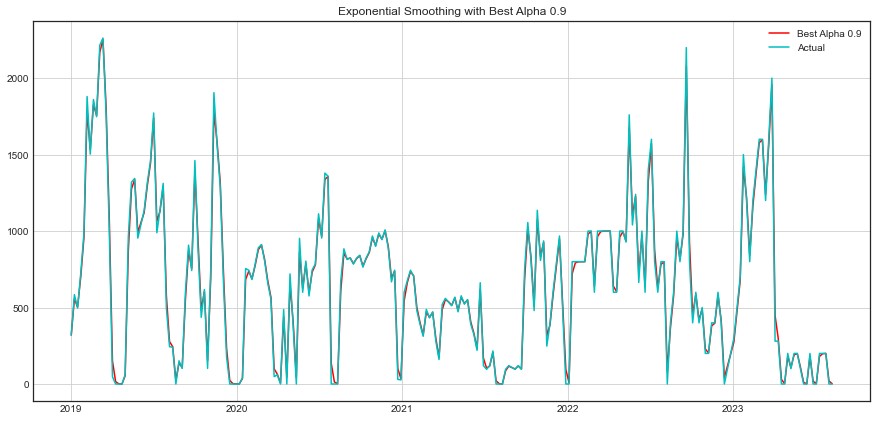

In [22]:
def plotExponentialSmoothing(series):
    """
    Plots exponential smoothing with best alpha

    series - dataset with timestamps

    """
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15, 7))

        best_alpha = find_best_alpha(series, alphas_to_try)
        smoothed_series = exponential_smoothing(series, best_alpha)

        plt.plot(series.index, smoothed_series, "r", label="Best Alpha {}".format(best_alpha))
        plt.plot(series.index, series, "c", label="Actual")

        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing with Best Alpha {}".format(best_alpha))
        plt.grid(True)
        plt.show()

# Assuming you already have the 'base.demande' DataFrame with weekly timestamps and demand data
# You can use the 'demande' column from 'base.demande' for the plotting
demand_series = base.demand

# Define the range of alpha values to try in the grid search
alphas_to_try = np.arange(0.1, 1.0, 0.1)

# Plot the exponential smoothing with the best alpha value only
plotExponentialSmoothing(demand_series)


In [23]:
def forecast_exponential_smoothing(series, alpha, forecast_steps):
    forecast = []
    level = series.iloc[-1]

    for _ in range(forecast_steps):
        forecast_value = alpha * level
        forecast.append(forecast_value)

        level = forecast_value

        # Update the series with the newly forecasted value
        series = series.append(pd.Series(forecast_value, index=[series.index[-1] + pd.DateOffset(weeks=1)]))

    return forecast


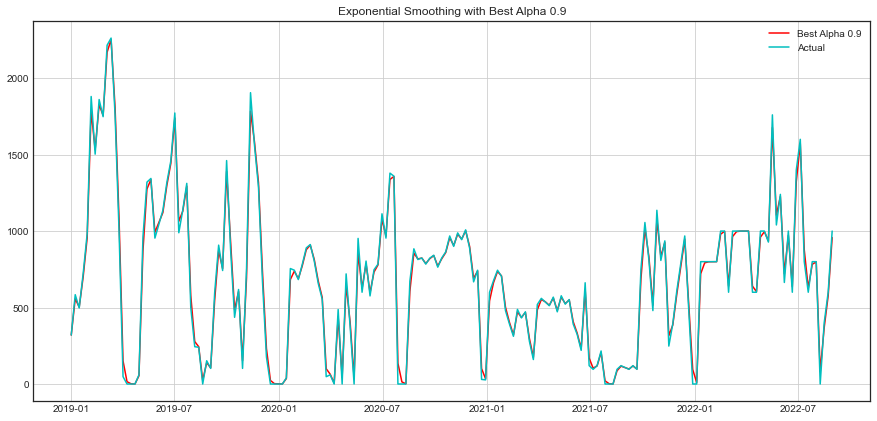

Mean Squared Error (MSE) on Test Data: 465549.1643086315
Forecast for Next 8 Weeks:
[900.0, 810.0, 729.0, 656.1, 590.49, 531.441, 478.29690000000005, 430.4672100000001]


In [24]:


# Assuming you already have the 'base.demande' DataFrame with weekly timestamps and demand data
# You can use the 'demande' column from 'base.demande' for the plotting
demand_series = base.demand

# Define the range of alpha values to try in the grid search
alphas_to_try = np.arange(0.1, 1.0, 0.1)

# Split data into train and test sets (e.g., train on 80% of data, test on 20%)
train_size = int(len(demand_series) * 0.8)
train_series, test_series = demand_series[:train_size], demand_series[train_size:]

# Get the forecasted values using the best alpha and plot the exponential smoothing
forecast_values = plotExponentialSmoothing(train_series)
# Evaluate the model on the test data
test_forecast = forecast_exponential_smoothing(train_series, find_best_alpha(train_series, alphas_to_try), len(test_series))
mse = mean_squared_error(test_series, test_forecast)
print("Mean Squared Error (MSE) on Test Data:", mse)
model_to_chose["exponential smoothing"]=mse
# Number of forecast steps for next weeks (e.g., 8 for eight weeks forecast)
forecast_steps_next_weeks = 8
forecast_next_weeks = forecast_exponential_smoothing(train_series, find_best_alpha(demand_series, alphas_to_try), forecast_steps_next_weeks)

print("Forecast for Next {} Weeks:".format(forecast_steps_next_weeks))
print(forecast_next_weeks)

In [25]:
mse

465549.1643086315

In [26]:
def forecast_next_weeks(series, best_alpha,forecast_steps):
    smoothed_series = exponential_smoothing(series, best_alpha)
    forecast_dates = pd.date_range(series.index[-1], periods=forecast_steps , freq='W-MON')[:]

    return smoothed_series[-forecast_steps:],forecast_dates

In [27]:
best_alpha=find_best_alpha(demand_series,alphas_to_try)

In [33]:
forecast_next_weeks(demand_series,best_alpha,forecast_steps)

([180.1099080296764,
  18.010990802967637,
  1.8010990802967632,
  180.18010990802966,
  198.01801099080296,
  199.8018010990803,
  19.980180109908027,
  1.9980180109908021],
 DatetimeIndex(['2023-08-14', '2023-08-21', '2023-08-28', '2023-09-04',
                '2023-09-11', '2023-09-18', '2023-09-25', '2023-10-02'],
               dtype='datetime64[ns]', freq='W-MON'))

In [34]:
forecast_values,forecast_dates=forecast_next_weeks(demand_series,best_alpha,8)

In [35]:
forecast_8_weeks["forecast Exponential Smoothing"]=forecast_values

In [36]:
forecast_8_weeks

,forecast Exponential Smoothing
0,180.109908
1,18.010991
2,1.801099
3,180.180110
4,198.018011
5,199.801801
6,19.980180
7,1.998018


In [37]:
forecast_8_weeks.set_index(forecast_dates)

,forecast Exponential Smoothing
2023-08-14,180.109908
2023-08-21,18.010991
2023-08-28,1.801099
2023-09-04,180.180110
2023-09-11,198.018011
2023-09-18,199.801801
2023-09-25,19.980180
2023-10-02,1.998018


## Double exponential smoothing

Up to now, the methods that we've discussed have been for a single future point prediction (with some nice smoothing). That is cool, but it is also not enough. Let's extend exponential smoothing so that we can predict two future points (of course, we will also include more smoothing).

Series decomposition will help us -- we obtain two components: intercept (i.e. level) $\ell$ and slope (i.e. trend) $b$. We have learnt to predict intercept (or expected series value) with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes. As a result, we get the following set of functions:

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

The first one describes the intercept, which, as before, depends on the current value of the series. The second term is now split into previous values of the level and of the trend. The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. In this case, the $\beta$ coefficient is a weight for exponential smoothing. The final prediction is the sum of the model values of the intercept and trend.

In [41]:
def calculate_mse(series, alpha, beta):
    smoothed_series = double_exponential_smoothing(series, alpha, beta)
    mse = mean_squared_error(series, smoothed_series)  # Ignore the first element as it is the same as the original series
    return mse
def estimate_best_alpha_beta(series, alphas, betas):
    best_alpha, best_beta, min_mse = None, None, np.inf
    for alpha in alphas:
        for beta in betas:
            mse = calculate_mse(series, alpha, beta)
            if mse < min_mse:
                min_mse = mse
                best_alpha, best_beta = alpha, beta
    return best_alpha, best_beta


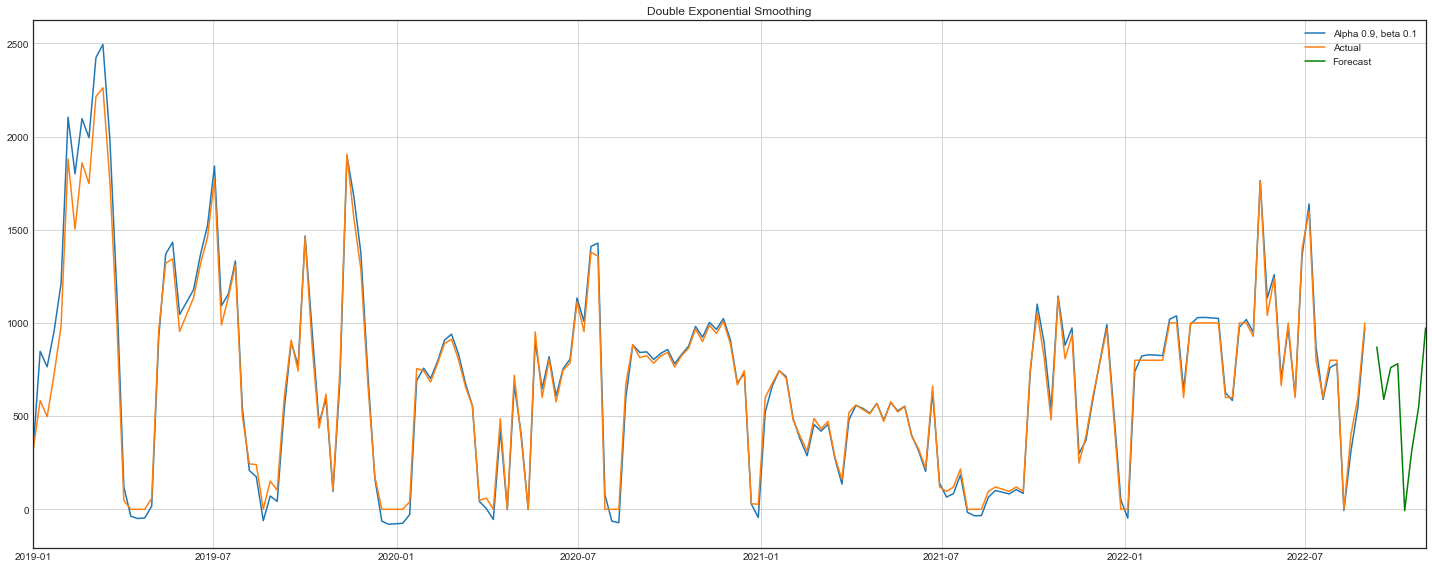

In [42]:
def double_exponential_smoothing(series, alpha, beta, forecast_steps):
    """
    series - dataset with timeseries
    alpha - float [0.0, 1.0], smoothing parameter for level
    beta - float [0.0, 1.0], smoothing parameter for trend
    forecast_steps - int, number of forecast steps into the future
    """
    # First value is same as series
    result = [series[0]]
    for n in range(1, len(series) + forecast_steps):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):  # Forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result[:len(series)]

def estimate_best_alpha_beta(series, alphas, betas):
    """
    Finds the best alpha and beta values based on the least MSE

    series - dataset with timestamps
    alphas - list of floats, smoothing parameters for level
    betas - list of floats, smoothing parameters for trend

    Returns:
    best_alpha - float, best alpha value based on least MSE
    best_beta - float, best beta value based on least MSE
    """
    best_mse = float('inf')
    best_alpha, best_beta = None, None

    for alpha in alphas:
        for beta in betas:
            mse = calculate_mse(series, alpha, beta,forecast_steps)
            if mse < best_mse:
                best_mse = mse
                best_alpha, best_beta = alpha, beta
    model_to_chose["double exponential smoothing"]=best_mse

    return best_alpha, best_beta

def calculate_mse(series, alpha, beta,forecast_steps):
    smoothed_series = double_exponential_smoothing(series, alpha, beta, forecast_steps)
    mse = mean_squared_error(series, smoothed_series)  # Ignore the first element as it is the same as the original series
    return mse

def plotDoubleExponentialSmoothing(series, alphas, betas, forecast_steps):
    """
    Plots double exponential smoothing with different alphas and betas

    series - dataset with timestamps
    alphas - list of floats, smoothing parameters for level
    betas - list of floats, smoothing parameters for trend
    forecast_steps - int, number of forecast steps into the future
    """
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(20, 8))
        alpha, beta = estimate_best_alpha_beta(series, alphas, betas)
        smoothed_series = double_exponential_smoothing(series, alpha, beta, forecast_steps)

        # Convert the index to datetime format if it's not already in that format
        if not isinstance(series.index, pd.DatetimeIndex):
            series.index = pd.to_datetime(series.index)

        plt.plot(series.index, smoothed_series, label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.index, series, label="Actual")

        # Forecast into the future
        forecast_dates = pd.date_range(series.index[-1], periods=forecast_steps + 1, freq='W')[1:]
        forecast_values = double_exponential_smoothing(series, alpha, beta, forecast_steps)
        plt.plot(forecast_dates, forecast_values[-forecast_steps:], 'g', label="Forecast")

        plt.legend(loc="best")
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

        # Adjust the x-axis date range to start from your specific date
        start_date = series.index[0]  # Replace this with your specific date
        plt.xlim(start_date, forecast_dates[-1])

        plt.tight_layout()
        plt.show()


# Assuming you already have the 'base.demande' DataFrame with weekly timestamps and demand data
# You can use the 'demande' column from 'base.demande' for the plotting
demand_series = base.demand

# Define the range of alpha and beta values to try in the grid search
alphas_to_try = np.arange(0.1, 1.0, 0.1)
betas_to_try = np.arange(0.1, 1.0, 0.1)

# Split data into train and test sets (e.g., train on 80% of data, test on 20%)
train_size = int(len(demand_series) * 0.8)
train_series, test_series = demand_series[:train_size], demand_series[train_size:]

# Get the forecasted values using the best alpha and beta and plot the double exponential smoothing
 # Adjust the number of forecast steps as needed
plotDoubleExponentialSmoothing(train_series, alphas_to_try, betas_to_try, forecast_steps)


In [43]:
def forecast_next_weeks(series, best_alpha, best_beta, forecast_steps):
    smoothed_series = double_exponential_smoothing(series, best_alpha, best_beta, forecast_steps)
    forecast_dates = pd.date_range(series.index[-1], periods=forecast_steps, freq='W-MON')[:]

    return smoothed_series[-forecast_steps:],forecast_dates

In [44]:
best_alpha,best_beta=estimate_best_alpha_beta(demand_series,alphas_to_try,betas_to_try)

In [45]:
forecast_values,forecast_dates=forecast_next_weeks(demand_series,best_alpha,best_beta,forecast_steps)

In [46]:
forecast_values

[148.761895494809,
 -24.407763253432456,
 -39.52803043544768,
 160.51746558554106,
 184.07544328494126,
 187.86445115923655,
 -8.6644486576652,
 -27.53753826016551]

In [47]:
forecast_8_weeks["Double Exponential Smoothing"]=forecast_values

In [48]:
forecast_8_weeks=forecast_8_weeks.set_index(forecast_dates)

In [49]:
forecast_8_weeks

,forecast Exponential Smoothing,Double Exponential Smoothing
2023-08-14,180.109908,148.761895
2023-08-21,18.010991,-24.407763
2023-08-28,1.801099,-39.528030
2023-09-04,180.180110,160.517466
2023-09-11,198.018011,184.075443
2023-09-18,199.801801,187.864451
2023-09-25,19.980180,-8.664449
2023-10-02,1.998018,-27.537538


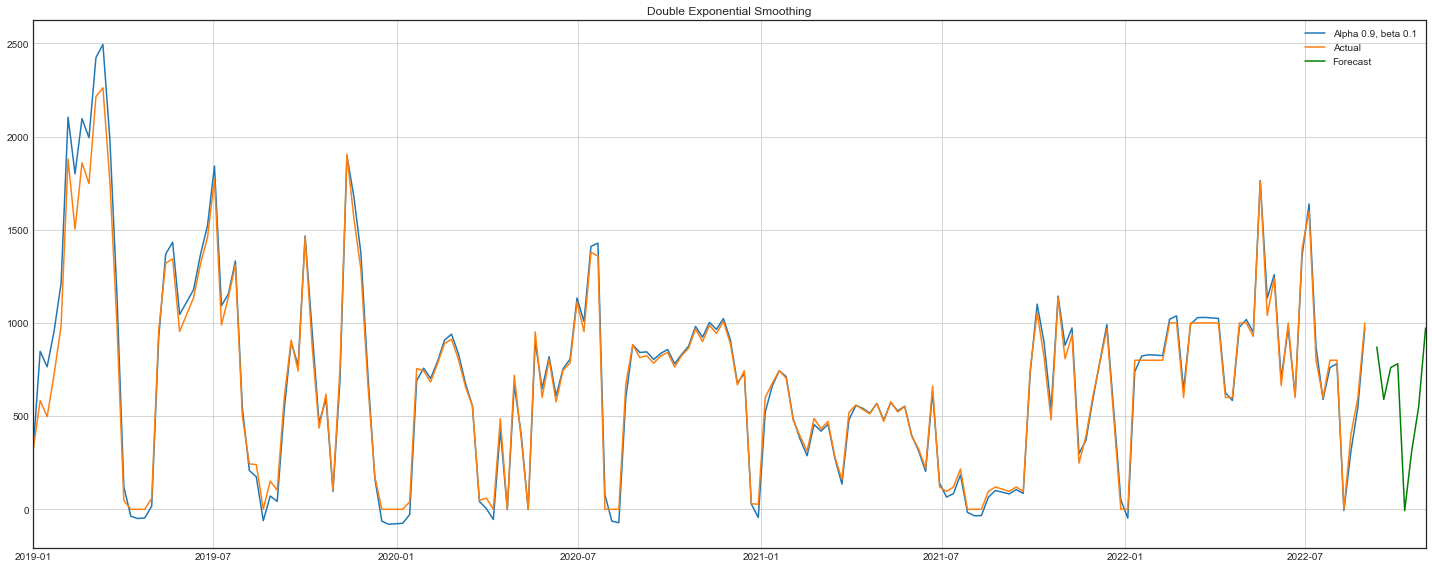

Forecast for the next 8 weeks:
2022-09-11    870.983042
2022-09-18    589.814559
2022-09-25    760.614401
2022-10-02    781.239089
2022-10-09     -7.009960
2022-10-16    310.796031
2022-10-23    548.604988
2022-10-30    973.011434
Freq: W-SUN, dtype: float64
Mean Squared Error (MSE) on Test Data: 7383.824848640844
Mean Squared Error (MSE) on Train Data: 5215.1703337339795


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# The implementations of double_exponential_smoothing, estimate_best_alpha_beta, calculate_mse,
# and plotDoubleExponentialSmoothing remain the same as provided earlier.

# Assuming you already have the 'base.demande' DataFrame with weekly timestamps and demand data
# You can use the 'demande' column from 'base.demande' for the plotting
demand_series = base.demand

# Define the range of alpha and beta values to try in the grid search
alphas_to_try = np.arange(0.1, 1.0, 0.1)
betas_to_try = np.arange(0.1, 1.0, 0.1)

# Split data into train and test sets (e.g., train on 80% of data, test on 20%)
train_size = int(len(demand_series) * 0.8)
train_series, test_series = demand_series[:train_size], demand_series[train_size:]

# Get the forecasted values using the best alpha and beta and plot the double exponential smoothing
forecast_steps =8  # Forecast for the next 8 weeks
plotDoubleExponentialSmoothing(train_series, alphas_to_try, betas_to_try, forecast_steps)

# Get the forecasted values for the next 8 weeks using the best alpha and beta
best_alpha, best_beta = estimate_best_alpha_beta(train_series, alphas_to_try, betas_to_try)
forecast_dates = pd.date_range(train_series.index[-1], periods=forecast_steps + 1, freq='W')[1:]
forecast_values = double_exponential_smoothing(train_series, best_alpha, best_beta, forecast_steps)

# Print the forecasted values
print("Forecast for the next 8 weeks:")
print(pd.Series(forecast_values[-forecast_steps:], index=forecast_dates))

# Evaluate the model on the test data
test_forecast = double_exponential_smoothing(test_series, best_alpha, best_beta, forecast_steps)
test_mse = mean_squared_error(test_series, test_forecast[:len(test_series)])
print("Mean Squared Error (MSE) on Test Data:", test_mse)

# Evaluate the model on the train data
train_forecast = double_exponential_smoothing(train_series, best_alpha, best_beta, forecast_steps)
train_mse = mean_squared_error(train_series, train_forecast[:len(train_series)])
print("Mean Squared Error (MSE) on Train Data:", train_mse)


In [51]:
forecast_8_weeks

,forecast Exponential Smoothing,Double Exponential Smoothing
2023-08-14,180.109908,148.761895
2023-08-21,18.010991,-24.407763
2023-08-28,1.801099,-39.528030
2023-09-04,180.180110,160.517466
2023-09-11,198.018011,184.075443
2023-09-18,199.801801,187.864451
2023-09-25,19.980180,-8.664449
2023-10-02,1.998018,-27.537538


## Triple exponential smoothing a.k.a. Holt-Winters

We've looked at exponential smoothing and double exponential smoothing. This time, we're going into _triple_ exponential smoothing.

As you could have guessed, the idea is to add a third component - seasonality. This means that we should not use this method if our time series is not expected to have seasonality. Seasonal components in the model will explain repeated variations around intercept and trend, and it will be specified by the length of the season, in other words by the period after which the variations repeat. For each observation in the season, there is a separate component; for example, if the length of the season is 7 days (a weekly seasonality), we will have 7 seasonal components, one for each day of the week.

With this, let's write out a new system of equations:

$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$

The intercept now depends on the current value of the series minus any corresponding seasonal component. Trend remains unchanged, and the seasonal component depends on the current value of the series minus the intercept and on the previous value of the component. Take into account that the component is smoothed through all the available seasons; for example, if we have a Monday component, then it will only be averaged with other Mondays. You can read more on how averaging works and how the initial approximation of the trend and seasonal components is done [here](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm). Now that we have the seasonal component, we can predict not just one or two steps ahead but an arbitrary $m$ future steps ahead, which is very encouraging.

Below is the code for a triple exponential smoothing model, which is also known by the last names of its creators, Charles Holt and his student Peter Winters. Additionally, the Brutlag method was included in the model to produce confidence intervals:

$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$

$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$

$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T},$$

where $T$ is the length of the season, $d$ is the predicted deviation. Other parameters were taken from triple exponential smoothing. You can read more about the method and its applicability to anomaly detection in time series [here](http://fedcsis.org/proceedings/2012/pliks/118.pdf).

In [52]:
def calculate_mse_g(series, alpha, beta,gamma):
    smoothed_series = triple_exponential_smoothing(series, alpha, beta,gamma,forecast_steps)
    mse = mean_squared_error(series, smoothed_series)  # Ignore the first element as it is the same as the original series
    return mse

def triple_exponential_smoothing(series, alpha, beta, gamma, forecast_steps):
    """
    series - dataset with timeseries
    alpha - float [0.0, 1.0], smoothing parameter for level
    beta - float [0.0, 1.0], smoothing parameter for trend
    gamma - float [0.0, 1.0], smoothing parameter for seasonality
    seasonal_periods - int, number of seasonal periods in a season
    forecast_steps - int, number of forecast steps into the future
    """
    # First value is same as series
    result = [series[0]]
    for n in range(1, len(series) + forecast_steps):
        if n == 1:
            level, trend, seasonal = series[0], series[1] - series[0], series[0]
        if n >= len(series):  # Forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend + seasonal)
        trend = beta * (level - last_level) + (1 - beta) * trend
        seasonal = gamma * (value - level - trend) + (1 - gamma) * seasonal
        result.append(level + trend + seasonal)
    return result[:len(series)]


def estimate_best_alpha_beta_gamma(series, alphas, betas, gammas):
    """
    Finds the best alpha, beta, and gamma values based on the least MSE

    series - dataset with timestamps
    alphas - list of floats, smoothing parameters for level
    betas - list of floats, smoothing parameters for trend
    gammas - list of floats, smoothing parameters for seasonality

    Returns:
    best_alpha - float, best alpha value based on least MSE
    best_beta - float, best beta value based on least MSE
    best_gamma - float, best gamma value based on least MSE
    """
    best_mse = float('inf')
    best_alpha, best_beta, best_gamma = None, None, None

    for alpha in alphas:
        for beta in betas:
            for gamma in gammas:
                mse = calculate_mse_g(series, alpha, beta, gamma)
                if mse < best_mse:
                    best_mse = mse
                    best_alpha, best_beta, best_gamma = alpha, beta, gamma
    model_to_chose["triple exponential smoothing"]=best_mse

    return best_alpha, best_beta, best_gamma


def plotTripleExponentialSmoothing(series, alphas, betas, gammas, forecast_steps):
    """
    Plots triple exponential smoothing with different alphas, betas, and gammas

    series - dataset with timestamps
    alphas - list of floats, smoothing parameters for level
    betas - list of floats, smoothing parameters for trend
    gammas - list of floats, smoothing parameters for seasonality
    forecast_steps - int, number of forecast steps into the future
    """
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(20, 8))
        alpha, beta, gamma = estimate_best_alpha_beta_gamma(series, alphas, betas, gammas)
        smoothed_series = triple_exponential_smoothing(series, alpha, beta, gamma, forecast_steps)

        # Convert the index to datetime format if it's not already in that format
        if not isinstance(series.index, pd.DatetimeIndex):
            series.index = pd.to_datetime(series.index)

        plt.plot(series.index, smoothed_series, label="Alpha {}, beta {}, gamma {}".format(alpha, beta, gamma))
        plt.plot(series.index, series, label="Actual")

        # Forecast into the future
        forecast_dates = pd.date_range(series.index[-1], periods=forecast_steps + 1, freq='W')[1:]
        forecast_values = triple_exponential_smoothing(series, alpha, beta, gamma, forecast_steps)
        plt.plot(forecast_dates, forecast_values[-forecast_steps:], 'g', label="Forecast")

        plt.legend(loc="best")
        plt.title("Triple Exponential Smoothing")
        plt.grid(True)

        # Adjust the x-axis date range to start from your specific date
        start_date = series.index[0]  # Replace this with your specific date
        plt.xlim(start_date, forecast_dates[-1])

        plt.tight_layout()
        plt.show()

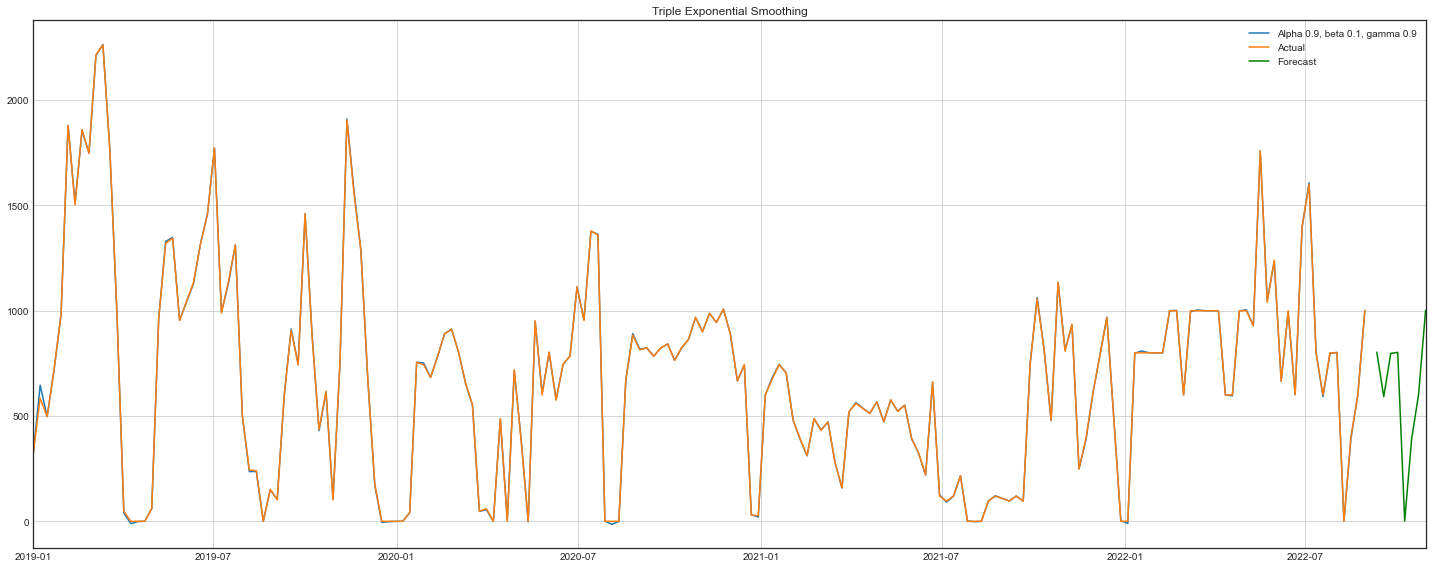

Forecast for the next 8 weeks:
2022-09-11     803.267809
2022-09-18     591.809459
2022-09-25     797.033184
2022-10-02     802.142378
2022-10-09       1.213355
2022-10-16     391.759230
2022-10-23     603.755323
2022-10-30    1002.523490
Freq: W-SUN, dtype: float64
Mean Squared Error (MSE) on Test Data: 273.06229869214144
Mean Squared Error (MSE) on Train Data: 35.77895755299136


In [53]:
gammas_to_try = np.arange(0.1, 1.0, 0.1)
alphas_to_try = np.arange(0.1, 1.0, 0.1)
betas_to_try = np.arange(0.1, 1.0, 0.1)
# Get the forecasted values using the best alpha and beta and plot the double exponential smoothing
forecast_steps =8  # Forecast for the next 8 weeks
plotTripleExponentialSmoothing(train_series, alphas_to_try, betas_to_try,gammas_to_try, forecast_steps)

# Get the forecasted values for the next 8 weeks using the best alpha and beta
best_alpha, best_beta,best_gamma = estimate_best_alpha_beta_gamma(train_series, alphas_to_try, betas_to_try,gammas_to_try)
forecast_dates = pd.date_range(train_series.index[-1], periods=forecast_steps + 1, freq='W')[1:]
forecast_values = triple_exponential_smoothing(train_series, best_alpha, best_beta,best_gamma, forecast_steps)

# Print the forecasted values
print("Forecast for the next 8 weeks:")
print(pd.Series(forecast_values[-forecast_steps:], index=forecast_dates))

# Evaluate the model on the test data
test_forecast = triple_exponential_smoothing(test_series, best_alpha, best_beta,best_gamma, forecast_steps)
test_mse = mean_squared_error(test_series, test_forecast[:len(test_series)])
print("Mean Squared Error (MSE) on Test Data:", test_mse)

# Evaluate the model on the train data
train_forecast = triple_exponential_smoothing(train_series, best_alpha, best_beta,best_gamma, forecast_steps)
train_mse = mean_squared_error(train_series, train_forecast[:len(train_series)])
print("Mean Squared Error (MSE) on Train Data:", train_mse)


In [54]:
test_series

date
2022-09-06     800
2022-09-13    1000
2022-09-20    2200
2022-09-27     800
2022-10-04     400
2022-10-11     600
2022-10-18     400
2022-10-25     500
2022-11-01     200
2022-11-08     200
2022-11-15     400
2022-11-22     400
2022-11-29     600
2022-12-06     400
2022-12-13       0
2023-01-03     300
2023-01-10     500
2023-01-17     700
2023-01-24    1500
2023-01-31    1200
2023-02-07     800
2023-02-14    1200
2023-02-21    1400
2023-02-28    1600
2023-03-07    1600
2023-03-14    1200
2023-03-21    1600
2023-03-28    2000
2023-04-04     280
2023-04-11     280
2023-04-18       0
2023-04-25       0
2023-05-02     200
2023-05-09     100
2023-05-16     200
2023-05-23     200
2023-05-30     100
2023-06-06       0
2023-06-13       0
2023-06-20     200
2023-06-27       0
2023-07-04       0
2023-07-11     200
2023-07-18     200
2023-07-25     200
2023-08-01       0
2023-08-08       0
Name: demand, dtype: int64

In [56]:
def forecast_next_weeks(series, best_alpha, best_beta,best_gamma, forecast_steps):
    smoothed_series = triple_exponential_smoothing(series, best_alpha, best_beta,best_gamma, forecast_steps)
    forecast_dates = pd.date_range(series.index[-1], periods=forecast_steps + 1, freq='W-MON')[:]

    return smoothed_series[-forecast_steps:],forecast_dates

In [57]:
best_alpha,best_beta,best_gamma=estimate_best_alpha_beta_gamma(demand_series,alphas_to_try,betas_to_try,gammas_to_try)

In [58]:
forecast_values,forecast_dates=forecast_next_weeks(demand_series,best_alpha,best_beta,best_gamma,forecast_steps)

In [59]:
forecast_8_weeks["triple Exponential Smoothing"]=forecast_values

In [60]:
forecast_8_weeks

,forecast Exponential Smoothing,Double Exponential Smoothing,triple Exponential Smoothing
2023-08-14,180.109908,148.761895,200.219516
2023-08-21,18.010991,-24.407763,2.687447
2023-08-28,1.801099,-39.528030,-1.513678
2023-09-04,180.180110,160.517466,199.973560
2023-09-11,198.018011,184.075443,202.368162
2023-09-18,199.801801,187.864451,200.382010
2023-09-25,19.980180,-8.664449,0.323082
2023-10-02,1.998018,-27.537538,-1.892086


In [61]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller


In [62]:

from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(base.demand, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))



 > Is the data stationary ?
Test statistic = -6.308
P-value = 0.000
Critical values :
	1%: -3.4586084859607156 - The data is  stationary with 99% confidence
	5%: -2.873972159235721 - The data is  stationary with 95% confidence
	10%: -2.57339565928848 - The data is  stationary with 90% confidence


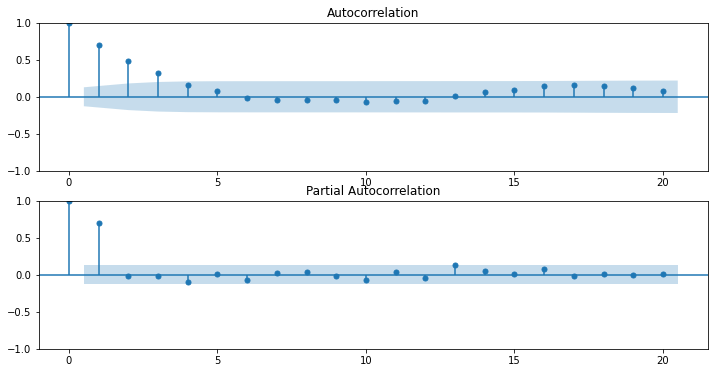

In [63]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(base.demand.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(base.demand.dropna(), ax=ax[1], lags=20)

In [64]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3) #this is the range for the values
q_values = range(0, 3) #this is the range for the values

In [65]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [66]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [67]:
warnings.filterwarnings("ignore")


In [68]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(dataset, order=order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                except:
                    continue

    if best_cfg is not None:
        print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    else:
        print('No valid ARIMA model found.')

evaluate_models(test_series, p_values, d_values, q_values)


No valid ARIMA model found.


In [69]:
evaluate_models(base.demand, p_values, d_values, q_values)


No valid ARIMA model found.


In [70]:
from statsmodels.tsa.arima_model import ARIMA


In [71]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

base.index.freq = base.index.inferred_freq
model2 = SARIMAX(base.demand, order=(4,0,2), seasonal_order=(0,1,0,12))
results = model2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              demand   No. Observations:                  235
Model:             SARIMAX(4, 0, 2)x(0, 1, [], 12)   Log Likelihood               -1706.300
Date:                             Fri, 18 Aug 2023   AIC                           3426.601
Time:                                     14:15:30   BIC                           3450.451
Sample:                                          0   HQIC                          3436.229
                                             - 235                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6822      0.073      9.318      0.000       0.539       0.826
ar.L2          0.8378      0.077     10.868      0.000       0.687       0.989
ar.L3         -0.5074      0.078     -6.504      0.000      -0.660      -0.354
ar.L4         -0.0959      0.076     -1.269      0.204      -0.244       0.052
ma.L1       9.563e-07    404.812   2.36e-09      1.000    -793.417     793.417
ma.L2         -1.0000      0.094    -10.689      0.000      -1.183      -0.817
sigma2      2.548e+05      0.002    1.6e+08      0.000    2.55e+05    2.55e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.87   Prob(JB):                         0.54
Heteroskedasticity (H):               1.08   Skew:                             0.11
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.95e+26. Standard errors may be unstable.
"""

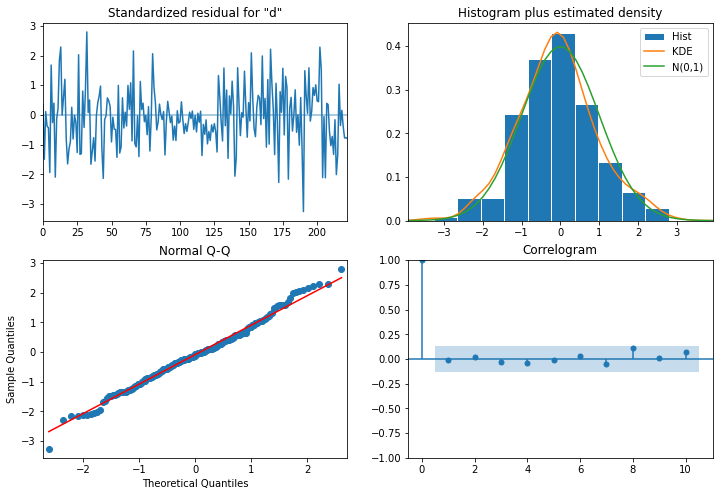

In [72]:
plt.rcParams['figure.figsize'] = 12, 8
plot = results.plot_diagnostics()
plt.show()


In [73]:
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

In [74]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [75]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Assuming you have a pandas DataFrame named 'data_sarima' with the time series data

# Define the range of p, d, and q values for SARIMA
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

# Define the range of seasonal P, D, and Q values for SARIMA
P = range(0, 2)
D = range(0, 2)
Q = range(0, 2)
m = 12  # Seasonal period

# Determing p, d, q, P, D, and Q combinations with AIC scores
best_aic = np.inf
best_mse = np.inf
best_order = None
best_seasonal_order = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(base.demand,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()
  # Calculate the MSE
        forecasted_values = results.get_forecast(steps=len(base.demand))
        forecasted_mean = forecasted_values.predicted_mean
        mse = (((base.demand - forecasted_mean) ** 2).mean())

        if mse<best_mse:
          best_mse=mse
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = param
            best_seasonal_order = param_seasonal

model_to_chose["sarima"]=best_mse

# Fit the SARIMAX model with the best order
best_model = sm.tsa.statespace.SARIMAX(base.demand,
                                       order=best_order,
                                       seasonal_order=best_seasonal_order,
                                       enforce_stationarity=False,
                                       enforce_invertibility=False)
best_results = best_model.fit()

print("Best order:", best_order)
print("Best seasonal order:", best_seasonal_order)
print("AIC:", best_results.aic)


Best order: (1, 1, 1)
Best seasonal order: (1, 1, 1, 12)
AIC: 3063.571989205705


In [77]:
# Fitting the data to SARIMA model
model_sarima = sm.tsa.statespace.SARIMAX(base.demand,
                                order=best_order,
                                seasonal_order=best_seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_sarima = model_sarima.fit()

print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6590      0.073      9.053      0.000       0.516       0.802
ma.L1         -0.9564      0.034    -28.161      0.000      -1.023      -0.890
ar.S.L12      -0.1485      0.064     -2.318      0.020      -0.274      -0.023
ma.S.L12      -1.0415      0.156     -6.681      0.000      -1.347      -0.736
sigma2      1.154e+05   2.54e+04      4.535      0.000    6.55e+04    1.65e+05


In [78]:
forecast = results_sarima.forecast(steps=forecast_steps)
last_date = base.demand.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=forecast_steps, freq='W-MON')[:]
print("Forecasted values for the next {} weeks:".format(forecast_steps))
print(forecast)

print("Forecast dates:")
print(forecast_dates)

Forecasted values for the next 8 weeks:
235    342.189751
236    373.427674
237    388.428466
238    639.754575
239    564.450082
240    405.853628
241    365.841422
242    360.205426
Name: predicted_mean, dtype: float64
Forecast dates:
DatetimeIndex(['2023-08-14', '2023-08-21', '2023-08-28', '2023-09-04',
               '2023-09-11', '2023-09-18', '2023-09-25', '2023-10-02'],
              dtype='datetime64[ns]', freq='W-MON')


In [79]:
forecast=list(forecast)

In [80]:
forecast_8_weeks["SARIMA"]=forecast

In [81]:
forecast_8_weeks

,forecast Exponential Smoothing,Double Exponential Smoothing,triple Exponential Smoothing,SARIMA
2023-08-14,180.109908,148.761895,200.219516,342.189751
2023-08-21,18.010991,-24.407763,2.687447,373.427674
2023-08-28,1.801099,-39.528030,-1.513678,388.428466
2023-09-04,180.180110,160.517466,199.973560,639.754575
2023-09-11,198.018011,184.075443,202.368162,564.450082
2023-09-18,199.801801,187.864451,200.382010,405.853628
2023-09-25,19.980180,-8.664449,0.323082,365.841422
2023-10-02,1.998018,-27.537538,-1.892086,360.205426


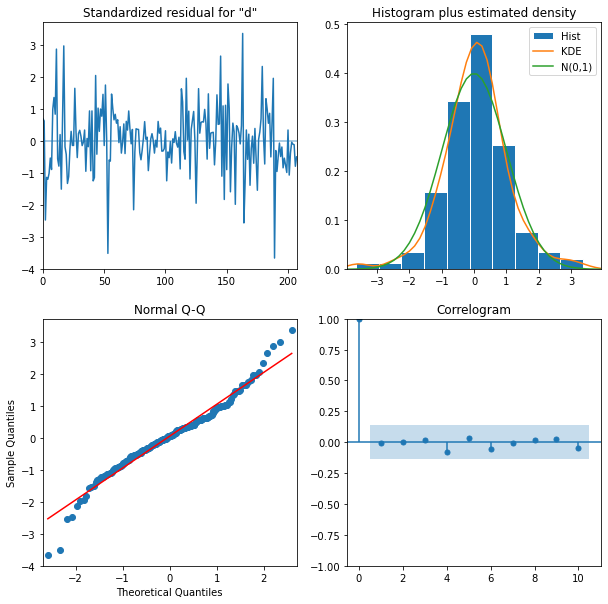

In [82]:
# Checking diagnostic plots
results_sarima.plot_diagnostics(figsize=(10, 10))
plt.show()

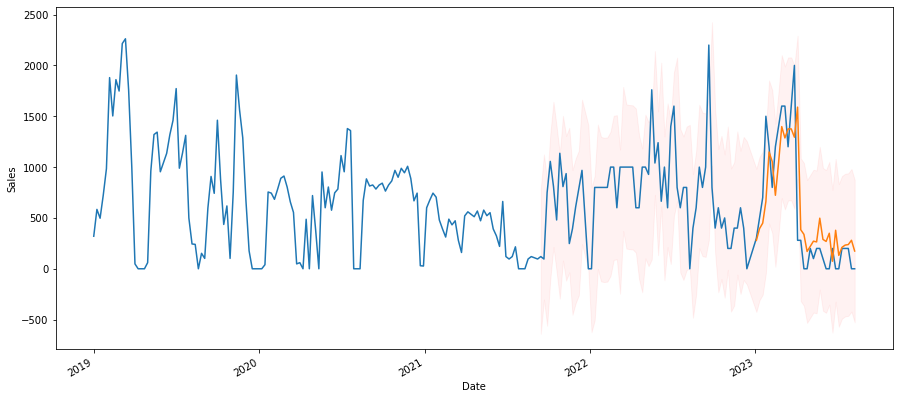

Root Mean Squared Error:  391.2468813625107


In [83]:
import math

pred = results_sarima.get_prediction(start=pd.to_datetime('2021-09-14	'), dynamic = False)

pred_ci = pred.conf_int()

ax = base.demand["2019":].plot(label = "observed", figsize=(15, 7))
pred.predicted_mean["2023":].plot(ax=ax, label="One-step ahead Forecast", alpha=1)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1],
                color = "r", alpha = 0.05)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")

plt.legend
plt.show()

data_sarima_forecasted = pred.predicted_mean
data_sarima_truth = base.demand["2021-09-14":]

#print(data_sarima_truth)
# # Calculating the error
rms_sarima = math.sqrt(mean_squared_error(data_sarima_truth, data_sarima_forecasted))
print("Root Mean Squared Error: ", rms_sarima)

In [84]:
forecast2=results_sarima.get_forecast(steps=forecast_steps)

In [85]:
forecast2

In [86]:

df_forecast2 = forecast2.summary_frame(alpha=0.05)
df_forecast2


demand,mean,mean_se,mean_ci_lower,mean_ci_upper
235,342.189751,357.750328,-358.988008,1043.367511
236,373.427674,437.392384,-483.845646,1230.700993
237,388.428466,473.636765,-539.882536,1316.739467
238,639.754575,492.670136,-325.861147,1605.370297
239,564.450082,503.785023,-422.950419,1551.850584
240,405.853628,510.928905,-595.548624,1407.255880
241,365.841422,515.880509,-645.265796,1376.948640
242,360.205426,519.736920,-658.460218,1378.871071


In [87]:
from statsmodels.tsa.arima.model import ARIMA as ARIMA


In [88]:
model = ARIMA(base.demand,order = (4,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 demand   No. Observations:                  235
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -1715.961
Date:                Fri, 18 Aug 2023   AIC                           3443.922
Time:                        14:16:25   BIC                           3464.679
Sample:                             0   HQIC                          3452.290
                                - 235                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        665.7063     79.735      8.349      0.000     509.428     821.985
ar.L1          0.7133      0.062     11.586      0.000       0.593       0.834
ar.L2         -0.0057      0.081     -0.071      0.9

In [89]:
model = ARIMA(base.demand,order = (0,0,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 demand   No. Observations:                  235
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -1728.394
Date:                Fri, 18 Aug 2023   AIC                           3464.787
Time:                        14:16:25   BIC                           3478.626
Sample:                             0   HQIC                          3470.366
                                - 235                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        665.2913     53.931     12.336      0.000     559.589     770.993
ma.L1          0.6594      0.062     10.700      0.000       0.539       0.780
ma.L2          0.3076      0.057      5.413      0.0

In [90]:
model = ARIMA(base.demand,order = (4,0,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 demand   No. Observations:                  235
Model:                 ARIMA(4, 0, 2)   Log Likelihood               -1714.982
Date:                Fri, 18 Aug 2023   AIC                           3445.964
Time:                        14:16:26   BIC                           3473.640
Sample:                             0   HQIC                          3457.122
                                - 235                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        658.1983     33.061     19.908      0.000     593.399     722.997
ar.L1          0.7075      0.073      9.725      0.000       0.565       0.850
ar.L2          0.9630      0.064     15.119      0.0

In [91]:
sarima = sm.tsa.statespace.SARIMAX(base.demand,order = best_order,seasonal_order = best_seasonal_order)
res_sarima = sarima.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 demand   No. Observations:                  235
Model:                 ARIMA(4, 0, 2)   Log Likelihood               -1714.982
Date:                Fri, 18 Aug 2023   AIC                           3445.964
Time:                        14:16:29   BIC                           3473.640
Sample:                             0   HQIC                          3457.122
                                - 235                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        658.1983     33.061     19.908      0.000     593.399     722.997
ar.L1          0.7075      0.073      9.725      0.000       0.565       0.850
ar.L2          0.9630      0.064     15.119      0.0

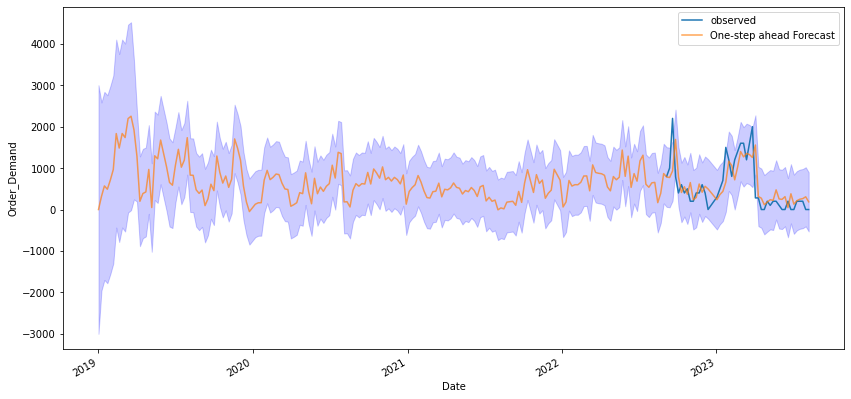

In [92]:
pred = res_sarima.get_prediction(start=base.index[0], dynamic=False) #false is when using the entire history.
#Confidence interval.
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
ax = base.demand[int(len(base.demand)*0.8):].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

In [93]:
forecast_8_weeks

,forecast Exponential Smoothing,Double Exponential Smoothing,triple Exponential Smoothing,SARIMA
2023-08-14,180.109908,148.761895,200.219516,342.189751
2023-08-21,18.010991,-24.407763,2.687447,373.427674
2023-08-28,1.801099,-39.528030,-1.513678,388.428466
2023-09-04,180.180110,160.517466,199.973560,639.754575
2023-09-11,198.018011,184.075443,202.368162,564.450082
2023-09-18,199.801801,187.864451,200.382010,405.853628
2023-09-25,19.980180,-8.664449,0.323082,365.841422
2023-10-02,1.998018,-27.537538,-1.892086,360.205426


In [94]:
# Specify the output file path
output_path = "C:/Users/hatta/OneDrive/Bureau/stage1/forecast_8_weeks.xlsx"

# Convert the DataFrame to an Excel file
forecast_8_weeks.to_excel(output_path, index=True)